In [1]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder

torch.manual_seed(42)

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Dispositivo usado: GPU con CUDA")
else:
  device = torch.device("cpu")
  print("Dispositivo usado: CPU")

Dispositivo usado: GPU con CUDA


In [3]:
# 1. Define Hyperparameters
hyperparams = {
    "batch_size": 32,
    "learning_rate": 0.001,
    "num_epochs": 20,
    "ridge_lambda": 0.01,
    "dropout_prob": 0.5,
    "scheduler_step_size": 7,
    "scheduler_gamma": 0.1
}

In [4]:
# Define the paths and labels
data_dirs = {
    r"C:\Users\nahue\Desktop\dataset\Lowlight_general"
    r"C:\Users\nahue\Desktop\dataset\GoodLight_general"
}

In [5]:
# 2. Data Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:

dataset = ImageFolder(root=r"C:\Users\nahue\Desktop\dataset\quality", transform=transform)

# Split into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print('Train dataset: ', train_size)
print('Test dataset: ', test_size)

train_loader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=False)

Train dataset:  32000
Test dataset:  8000


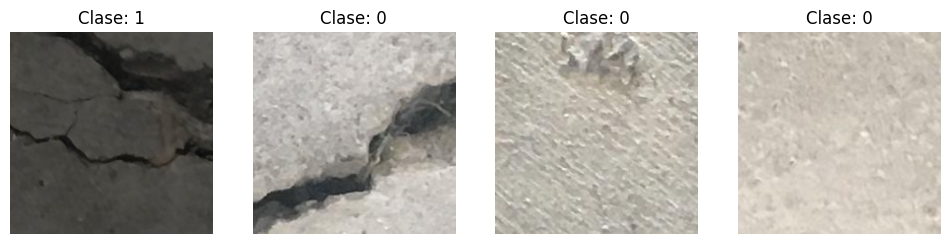

In [30]:
# Obtener un lote de imágenes
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Desnormalizar las imágenes (si es que se ha aplicado normalización)
# Como estamos usando ImageNet como ejemplo, la normalización fue con estos valores
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# Desnormalizar
images = images * std[:, None, None] + mean[:, None, None]

# Visualizar las imágenes
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    # Convertir el tensor de imagen a formato numpy para mostrar con matplotlib
    img = images[i].permute(1, 2, 0).cpu().numpy()  # Reordenar dimensiones de (C, H, W) a (H, W, C)
    
    # Asegurarse de que los valores estén dentro del rango [0, 1]
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img)
    axes[i].set_title(f"Clase: {labels[i].item()}")
    axes[i].axis('off')  # Desactivar los ejes
plt.show()

In [7]:
#ResNet18
def get_resnet(num_classes = 1):
  model = models.resnet18(pretrained=False) #Voy a entrenar todas las layers.

  ### Ajuste de estructura ###
  model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, num_classes),
        ) 


  return model

In [8]:
from tqdm import tqdm #Barra de progreso

def train(model, epoch):

    #Modelo para entrenamiento
    model.train()
    running_loss = 0
    #Barra de progreso
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{training_epochs}', leave=True)

    for images, labels in progress_bar:
        # Extraigo data del batch
        images, labels = images.to(device), labels.to(device)

        # Gradientes a 0 del optimizer
        optimizer.zero_grad()

        # Predigo
        output = model(images)
        labels = labels.float().unsqueeze(1)
        # Calculo loss
        loss = criterion(output, labels)

        # Backprogation
        loss.backward()

        # Actualizo pesos
        optimizer.step()

        # Actualizo la pérdida acumulada
        running_loss += loss.item()

        # Actualizo la barra de progreso con la pérdida promedio hasta ahora
        progress_bar.set_postfix({'loss': running_loss / (progress_bar.n + 1)})

    # Calculo la pérdida promedio del epoch
    avg_loss = running_loss / len(train_loader)
    loss_training.append(avg_loss)

    # Printeo resultado final del epoch
    print(f'Epoch {epoch + 1}/{training_epochs}, Loss: {avg_loss:.4f}')

In [9]:
def test(model, split):
    # Defino set
    if split == 'train':
        loader = train_loader
        loss_history = loss_train_split
    else:
        loader = test_loader
        loss_history = loss_test_split

    # Seteo el modelo en evaluación
    model.eval()

    global errorList
    errorList = []
    correct = 0
    test_loss = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            # Predigo
            output = model(data)

            # Si estamos usando BCEWithLogitsLoss, no es necesario aplicar Sigmoid
            # Si usas BCELoss, aplica Sigmoid
            output = torch.sigmoid(output)  # Convierte en probabilidades

            target = target.float().unsqueeze(1)  # Aseguramos que las etiquetas sean flotantes y tengan la forma correcta

            # Calculo la pérdida y sumo
            loss = criterion(output, target)
            test_loss += loss.item()

            # Predicción binaria: umbral en 0.5
            pred = (output > 0.5).float()  # 0.5 como umbral para clasificación binaria

            # Cuento cuántas son correctas
            correct += pred.eq(target).sum().item()

            # Identifico y guardo los errores
            errors = pred.ne(target)
            error_indices = errors.nonzero(as_tuple=True)[0]
            for idx in error_indices:
                errorList.append({
                    "data": data[idx],
                    "pred": pred[idx],
                    "target": target[idx]
                })

        # Calculo la pérdida promedio por batch
        test_loss /= len(loader)

        # Guardo el histórico de la pérdida en el test para graficarlo
        loss_history.append(test_loss)

        # Imprimo por pantalla los resultados del test
        print(f'Test (split {split}):\n   Loss medio: {test_loss:.4f}, '
              f'Errores: {len(errorList)}, '
              f'Precisión: {100. * correct / len(loader.dataset):.2f}%\n')


In [10]:
torch.manual_seed(42)

loss_training = []
loss_test_split = []
loss_train_split = []

#Model
model = get_resnet()
model.to(device)


#Estabilizamos los weights iniciales para facilitar la convergencia
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

model = model.apply(weights_init) #Aplicamos nuevos weights


#Criterion + optimizer con caida de lr
optimizer = torch.optim.SGD(model.parameters(), lr=1.5) #Optimizer
criterion = torch.nn.BCEWithLogitsLoss() #Loss function
scheduler = StepLR(optimizer, step_size=1, gamma=0.7) #Ajuste de LR


#Loop de entrenamiento 👌
training_epochs = 3
for epoch in range(0, training_epochs):
    print('Epoch :', epoch+1, 'LR:', scheduler.get_last_lr())

    train(model, epoch)
    test(model, 'test')

    scheduler.step()

C:\Users\nahue\anaconda3\envs\zerodce_env\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\nahue\anaconda3\envs\zerodce_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch : 1 LR: [1.5]


Epoch 1/3: 100%|██████████████████████████████████████████████████████| 1000/1000 [01:40<00:00,  9.99it/s, loss=0.0296]


Epoch 1/3, Loss: 0.0296
Test (split test):
   Loss medio: 0.5023, Errores: 2, Precisión: 99.97%

Epoch : 2 LR: [1.0499999999999998]


Epoch 2/3: 100%|██████████████████████████████████████████████████████| 1000/1000 [01:36<00:00, 10.34it/s, loss=0.0148]


Epoch 2/3, Loss: 0.0148
Test (split test):
   Loss medio: 0.5025, Errores: 6, Precisión: 99.92%

Epoch : 3 LR: [0.7349999999999999]


Epoch 3/3: 100%|█████████████████████████████████████████████████████| 1000/1000 [01:36<00:00, 10.34it/s, loss=0.00337]


Epoch 3/3, Loss: 0.0034
Test (split test):
   Loss medio: 0.5066, Errores: 1, Precisión: 99.99%



In [11]:
# 6. Test Function
def test_epoch(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()

            # Predicción del modelo
            outputs = model(images)

            # Si estamos usando BCEWithLogitsLoss, no es necesario aplicar Sigmoid
            # Si usamos BCELoss, aplicamos Sigmoid
            outputs = torch.sigmoid(outputs)  # Convierte los logits en probabilidades

            # Predicción binaria: umbral en 0.5
            preds = (outputs > 0.5).float()  # 0.5 como umbral para clasificación binaria

            # Convertir a CPU y agregar a las listas
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# 8. Test the Model
test_preds, test_labels = test_epoch(model, test_loader)


               precision    recall  f1-score   support

Regular Light       1.00      1.00      1.00      3973
    Low Light       1.00      1.00      1.00      4027

     accuracy                           1.00      8000
    macro avg       1.00      1.00      1.00      8000
 weighted avg       1.00      1.00      1.00      8000



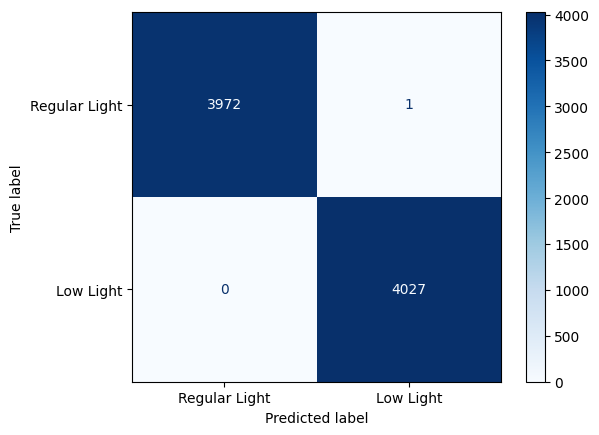

In [12]:
# Metrics and Confusion Matrix
print(classification_report(test_labels, test_preds, target_names=["Regular Light", "Low Light"]))
cm = confusion_matrix(test_labels, test_preds)
ConfusionMatrixDisplay(cm, display_labels=["Regular Light", "Low Light"]).plot(cmap="Blues")
plt.show()

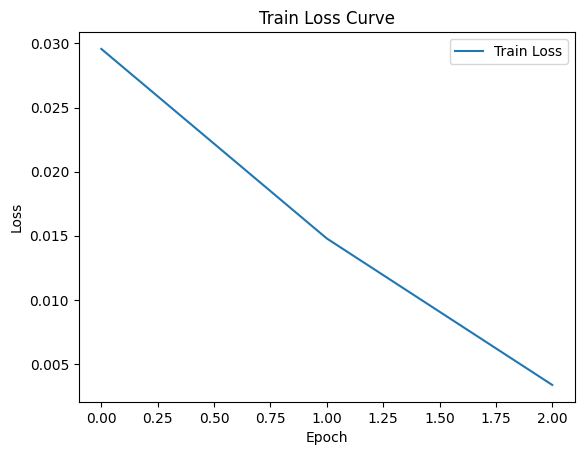

In [13]:
# 9. Plot Train Loss
plt.plot(loss_training, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train Loss Curve")
plt.show()

In [14]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# Save the model in .pth format (PyTorch format)
torch.save(model.state_dict(), 'quality_model.pth')

In [19]:
test_preds

[array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], d

In [20]:
test_labels

[1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
